Before you turn this lab in, make sure everything runs as expected. First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all cells** (in the menubar, select Cell$\rightarrow$Run All).

Make sure you fill in any place that says `YOUR CODE HERE` or "YOUR ANSWER HERE", as well as your name and collaborators below:

In [1]:
DRIVER = "Srini"
NAVIGATOR = "Jon"

# Generative Adversarial Networks Training Lab

Welcome to the generative adversarial networks lab! By the end of this lab, you will have

- Hooked together a generator $\mathcal{G}$ and discriminator $\mathcal{D}$ to build a generative adversarial model $\mathcal{A}$
- Optimized $\mathcal{G}$ to produce realistic data points via adversarial training

Let's get started!

# Unit Test Variables

The following code defines variables that will be used in subsequent unit tests. Do not attempt to redefine any of these variables throughout the notebook!

In [2]:
import numpy as np
np.random.seed(42)

BS_ = 128
Z_ = np.random.uniform(low=-1, high=1, size=BS_)

def passed(): print('✅')

# Synthetic Data

The following code defines a python generator which yields samples from a normal distribution and plots 1,000 samples.

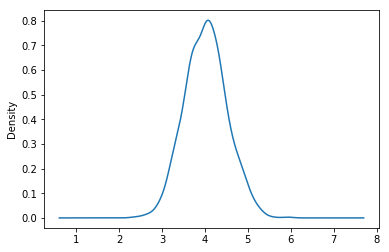

In [3]:
import numpy as np
import pandas as pd
%matplotlib inline

def data_distribution(mu, sigma):
    while True:
        z = sigma*np.random.randn() + mu
        yield z
        
data_point = data_distribution(mu=4, sigma=0.5)
pd.Series(next(data_point) for _ in range(1_000)).plot(kind='kde');

## Task

- Load $\mathcal{G}$ and $\mathcal{D}$ into memory

## Requirement

- Save them into python variables named `G` and `D` respectively

In [4]:
from keras.models import load_model

G = load_model('G.h5')
D = load_model('D.h5')
# YOUR CODE HERE
#raise NotImplementedError()

Using TensorFlow backend.
/Users/srianant/anaconda/envs/dl/lib/python3.6/site-packages/keras/models.py:240: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


# Load Models Tests

In [5]:
import keras

assert type(G) == keras.models.Sequential
assert G.input_shape == (None, 1)
assert G.output_shape == (None, 1)
assert G.predict(Z_).shape == (128, 1)
assert type(D) == keras.models.Sequential
assert D.output_shape == (None, 1)
assert D.input_shape == (None, 1)

passed()

✅


## Task

- Hook together $\mathcal{G}$ and $\mathcal{D}$ to create $\mathcal{A}$

## Hints

- Use the keras functional api to connect together $\mathcal{G}$ and $\mathcal{D}$
- Recall the interface for $\mathcal{A}$

<img src="images/Fancy GAN.svg" alt="GAN" style="width: 300px;"/>

## Requirements

- Save $\mathcal{A}$ into a python variable named `GAN`

## Hint

- Use `keras.layers.Input` as the first layer in your model to specify the input size

In [6]:
G.input_shape, G.output_shape, D.loss, D.metrics, type(D.optimizer)

((None, 1),
 (None, 1),
 'binary_crossentropy',
 ['accuracy'],
 keras.optimizers.Adam)

In [7]:
G.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 200)               400       
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 201       
Total params: 601.0
Trainable params: 601
Non-trainable params: 0.0
_________________________________________________________________


In [8]:
from keras.layers import Input
from keras.models import Model

z = Input(shape=[1])
X_fake = G(z)
p = D(X_fake)

GAN = Model(inputs=z, outputs=p, name='GAN')
GAN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

GAN.summary()
#raise NotImplementedError()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 1)                 0         
_________________________________________________________________
sequential_1 (Sequential)    (None, 1)                 601       
_________________________________________________________________
sequential_2 (Sequential)    (None, 1)                 601       
Total params: 1,202.0
Trainable params: 1,202.0
Non-trainable params: 0.0
_________________________________________________________________


# Generative Adversarial Network Tests

In [9]:
import numpy as np

def test_gan(G, D, GAN):
    assert type(GAN) == keras.engine.training.Model
    assert GAN.input_shape == G.input_shape
    assert GAN.output_shape == D.output_shape
    assert GAN.loss == D.loss
    assert GAN.metrics == D.metrics
    assert type(GAN.optimizer) == type(D.optimizer)
    bs_ = 16
    z_ = np.random.uniform(low=-1, high=1, size=[bs_, 1])
    X_fake_ = G.predict(z_)
    assert np.all(GAN.predict(z_) == D.predict(X_fake_))
    
    for l1, l2 in zip(GAN.layers[1].layers, G.layers):
        W1 = [ww for w in l1.get_weights() for ww in w]
        W2 = [ww for w in l2.get_weights() for ww in w]
        for w1, w2 in zip(W1, W2):
            assert np.all(w1 == w2)
        
    for l1, l2 in zip(GAN.layers[2].layers, D.layers):
        W1 = [ww for w in l1.get_weights() for ww in w]
        W2 = [ww for w in l2.get_weights() for ww in w]
        for w1, w2 in zip(W1, W2):
            assert np.all(w1 == w2)
    
test_gan(G, D, GAN)
passed()

✅


# Building Up to the Full Training Loop Solution

## Task

- Train $\mathcal{D}$ on a batch of two data points ${\tt X = [\widetilde{x} \ ; x]}$ and ${\tt y = [0, 1]}$

## Requirements

- Save your sample from the noise distribution into a python variable named `z`
- Save your batch of two training examples into python variables named `X` and `y`
- Save the accuracy and loss into python variables named `accuracy` and `loss`

In [41]:
NB_SAMPLE_ = 100
z = np.random.uniform(low=-1, high=1, size=[NB_SAMPLE_, 1])
X_fake = G.predict(z)

X_real = np.asarray([next(data_point) for _ in range(NB_SAMPLE_)]).reshape((NB_SAMPLE_, 1))

z = X_fake[0].reshape((1, 1))

# y_real, y_fake = np.ones(NB_SAMPLE_), np.zeros(NB_SAMPLE_)
# X, y = np.concatenate([X_fake, X_real]), np.concatenate([y_fake, y_real])
X = np.asarray([X_fake[0], X_real[0]])
y = np.asarray([0, 1])

loss, accuracy = D.evaluate(X, y, verbose=0) 
#raise NotImplementedError()

In [42]:
len(X)

2

# Discriminator Training Tests

In [43]:
assert z.shape == (1, 1)
assert len(X) == 2
assert np.all(y == [0, 1])
l_, a_ = D.train_on_batch(X, y)
assert l_ <= loss
assert a_ >= accuracy

W_d_ = [w for layer in D.layers for w in layer.get_weights()]
W_g_ = [w for layer in G.layers for w in layer.get_weights()]

passed()

✅


## Task

- Train $\mathcal{G}$ on a single adversarial training example `(z, 1)`

## Hints

- Make sure you freeze the weights of the discriminator so you don't step $\theta_\mathcal{D}$ in the wrong direction!
- You can use the `lib.keras_utils.freeze()` context manager to freeze $\mathcal{D}$'s weights. Here is an example illustrating usage and semantics.

#### Without `lib.keras_utils.freeze()`

```python
p = D.predict(X)
GAN.train_on_batch(z, y)
assert D.predict(X) != p # different weights, different prediction
```

#### With `lib.keras_utils.freeze()`

```python
from lib.keras_utils import freeze
with freeze(GAN, D):
    X_fake = G.predict(z)
    p = D.predict(X_fake)
    GAN.train_on_batch(z, y)
    assert D.predict(X_fake) == p # same weights, same prediction for D
    assert G.predict(z) != X_fake # different weights, different prediction for G
```

## Reminder

- Make sure you do **not** update $\theta_\mathcal{D}$!

In [44]:
from lib.keras_utils import freeze

with freeze(GAN, D):
    test = G.predict(z)
    p = D.predict(test)
    
    loss, acc = GAN.train_on_batch(z, np.asarray([y[0],]))
    
    assert D.predict(test) == p
    assert G.predict(z) != test

# Generator Training Tests

In [45]:
for w_d_old_, w_d_new_ in zip(W_d_, [w for layer in D.layers for w in layer.get_weights()]):
    assert np.all(w_d_old_ == w_d_new_)
    
test_gan(G, D, GAN)
passed()

✅


## Task

- Generalize your code to train $\mathcal{G}$ to produce realistic synthetic images with generative adversarial training

## Suggestions

- Track the loss for $\mathcal{G}$ and $\mathcal{D}$ over time as well as accuracy for $\mathcal{A}$ to see who is winning
- Have $\mathcal{G}$ generate some images every few epochs to visualize what it is learning

## Goal

- Optimize $\mathcal{G}$ so that it maps the 128 data points `Z_` (defined in the first code cell in this lab) from the noise distribution to data points close to the data points from the data distribution

## Constraints

- Do not run for more than 250 epochs

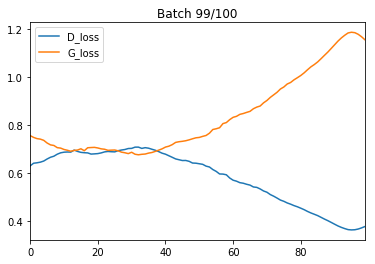

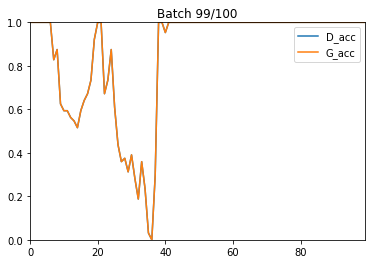

In [46]:
from IPython import display
import matplotlib.pyplot as plt
from collections import defaultdict
from lib.keras_utils import freeze

batch_size = 64
nb_epoch = 100
plot_every = 1
y_fake, y_real = np.zeros(batch_size), np.ones(batch_size)


L, A = defaultdict(list), defaultdict(list)
for i in range(nb_epoch):
    z = np.random.uniform(low=-1, high=1, size=[batch_size, 1])
    X_real, X_fake = np.asarray([next(data_point) for _ in range(batch_size)]).reshape((batch_size, 1)), G.predict(z)
    X, y = np.concatenate([X_fake, X_real]), np.concatenate([y_fake, y_real])
    loss, accuracy = D.train_on_batch(X, y)
    loss, accuracy = D.evaluate(X_fake, y_fake)
    L['D_loss'].append(float(loss)); A['D_acc'].append(float(accuracy))
    
    z = np.random.uniform(low=-1, high=1, size=[batch_size, 1])
    with freeze(GAN, D):
        loss, acc = GAN.train_on_batch(z, y_real)
    L['G_loss'].append(float(loss)); A['G_acc'].append(float(accuracy))
    
    if i == 0 or not i % plot_every == 0:
        continue
        
    display.clear_output(wait=True)
    pd.DataFrame(L).plot(title='Batch {}/{}'.format(i, nb_epoch))
    axes = pd.DataFrame(A).plot(title='Batch {}/{}'.format(i, nb_epoch))
    axes.set_ylim([0, 1])
    plt.show()
#raise NotImplementedError()

In [48]:
X_real.shape, X_fake.shape, y_fake.shape, y_real.shape

((64, 1), (64, 1), (64,), (64,))

## Task

- Plot samples from your trained generator and samples from the real data distribution on the same plot

## Requirements

- Use a *kernel density estimation* plot for both types of samples

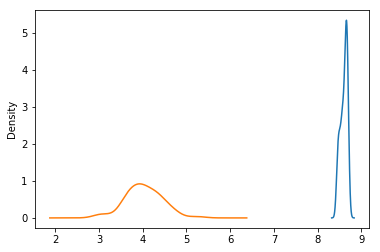

In [49]:
X_real = np.asarray([next(data_point) for _ in range(batch_size)]).reshape((batch_size, 1))
X_fake = G.predict(np.random.uniform(low=-1, high=1, size=batch_size))

pd.Series(X_fake.ravel()).plot(kind='kde')
pd.Series(X_real.ravel()).plot(kind='kde');
#raise NotImplementedError()

## Task

- Evaluate $\mathcal{D}$'s accuracy on the fake images $\mathcal{G}$ produces from `Z_`

## Requirements

- Save them into two python variables `loss` and `acc`

In [50]:
loss, acc = D.evaluate(X_fake, y_fake)
#raise NotImplementedError()

32/64 [==============>...............] - ETA: 0s

In [51]:
len(Z_)

128

# Evaluate $\mathcal{D}$ Tests

In [52]:
assert type(loss) == np.float64
assert type(acc) == np.float64
assert 0 <= acc <= 1

passed()

✅


# Evaluate $\mathcal{G}$ Tests

In [53]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 0.5
passed()

✅


In [54]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 1.0
passed()

✅


In [55]:
X_fake_ = G.predict(Z_)
assert X_fake_.mean() > 1.5
passed()

✅
